In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
import pandas as pd
import tensorflow as tf
import keras
import seaborn as sns
import time
import os
import sys

from statsmodels.graphics.tsaplots import plot_acf
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping

sys.path.append(os.path.abspath('../Data'))

import queries

In [2]:
server = 'VT3'
schema = 'WCS01600'
features = queries.get_profit_by_month(server, schema)

In [5]:
class TargetTransformer:
    """
    Perform some transformation on the time series
    data in order to make the model more performant and
    avoid non-stationary effects.
    """

    def __init__(self, log=False, detrend=False, diff=False):

        self.trf_log = log
        self.trf_detrend = detrend
        self.trend = pd.Series(dtype=np.float64)

    def transform(self, index, values):
        """
        Perform log transformation to the target time series

        :param index: the index for the resulting series
        :param values: the values of the initial series

        Return:
            transformed pd.Series
        """
        res = pd.Series(index=index, data=values)

        if self.trf_detrend:
            self.trend = TargetTransformer.get_trend(res) - np.mean(res.values)
            res = res.subtract(self.trend)

        if self.trf_log:
            res = pd.Series(index=index, data=np.log(res.values))

        return res

    def inverse(self, index, values):
        """
        Go back to the original time series values

        :param index: the index for the resulting series
        :param values: the values of series to be transformed back

        Return:
            inverse transformed pd.Series
        """
        res = pd.Series(index=index, data=values)

        if self.trf_log:
            res = pd.Series(index=index, data=np.exp(values))
        try:
            if self.trf_detrend:
                assert len(res.index) == len(self.trend.index)
                res = res + self.trend

        except AssertionError:
            print("Use a different transformer for each target to transform")

        return res

    @staticmethod
    def get_trend(data):
        """
        Get the linear trend on the data which makes the time
        series not stationary
        """
        n = len(data.index)
        X = np.reshape(np.arange(0, n), (n, 1))
        y = np.array(data)
        model = LinearRegression()
        model.fit(X, y)
        trend = model.predict(X)
        return pd.Series(index=data.index, data=trend)


In [17]:
def ts_analysis_plots(data, n_lags=12):

    def plot_cf(ax, fn, data, n_lags):
        """
        Plot autocorrelation functions for the loads
        """
        fn(data, ax=ax, lags=n_lags, color="#0504aa")
        for i in range(1, 5):
            ax.axvline(x=24*i, ymin=0.0, ymax=1.0, color='grey', ls="--")

    # AD Fuller test and linear trend of the time series
    trend = TargetTransformer.get_trend(data)
    adf = adfuller(data)

    fig, axs = plt.subplots(2, 2, figsize=(25, 12))
    axs = axs.flat

    # original time series
    axs[0].plot(data, color='#0504aa')
    axs[0].plot(trend, color="red")
    axs[0].set(xlabel="Date", ylabel="Profits",
               title=f"Profits over time (ADF p-value: {round(adf[1], 6)})")

    # histogram of value distribution
    axs[1].hist(data, bins=20, width = 3, color='#0504aa',alpha=0.7)
    axs[1].set(xlabel="Profits", ylabel="# data points", title="Profits distribution")

    # autocorrelation function
    plot_cf(axs[2], plot_acf, data, n_lags)
    axs[2].set(xlabel="lag", ylabel="ACF value")

    # partial autocorrelation function
    plot_cf(axs[3], plot_pacf, data, n_lags)
    axs[3].set(xlabel="lag", ylabel="PACF value")

    plt.show()

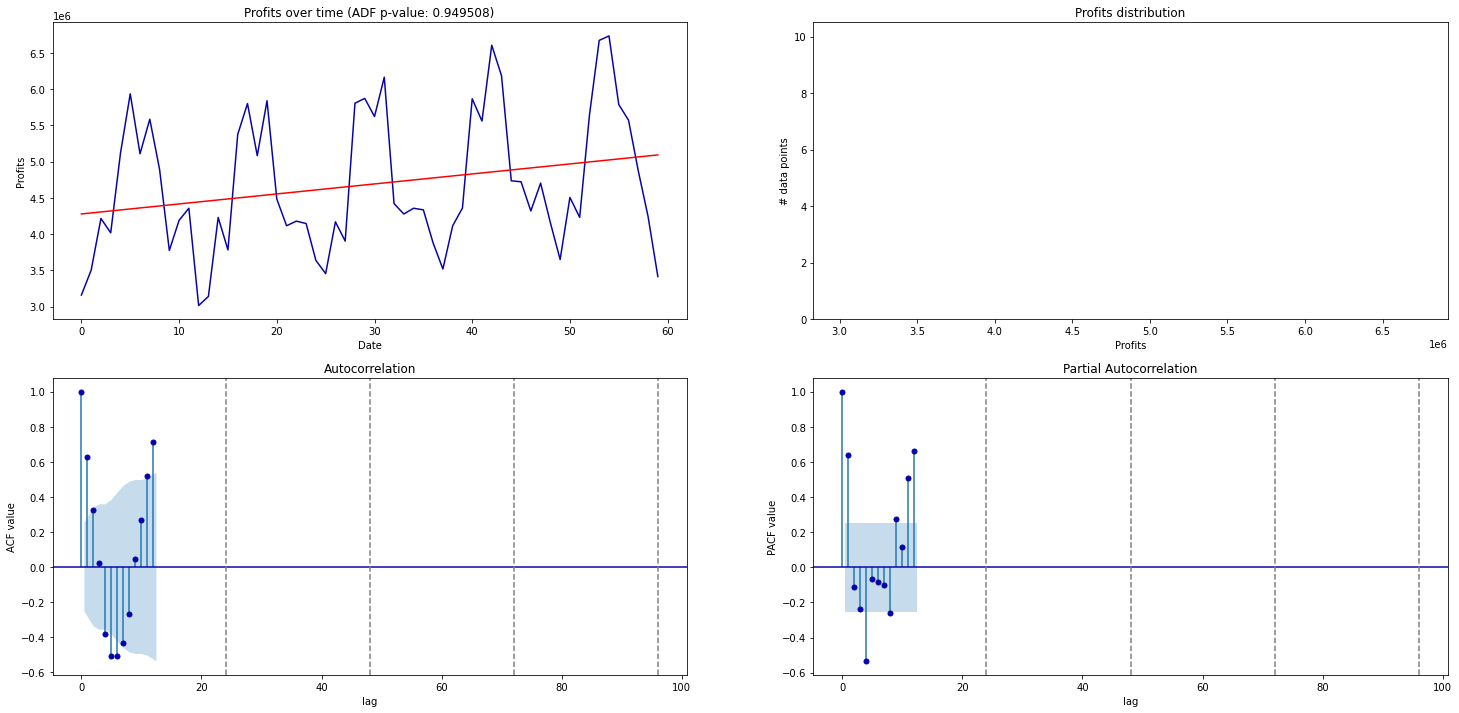

In [20]:
ts_analysis_plots(features['PROFIT'])

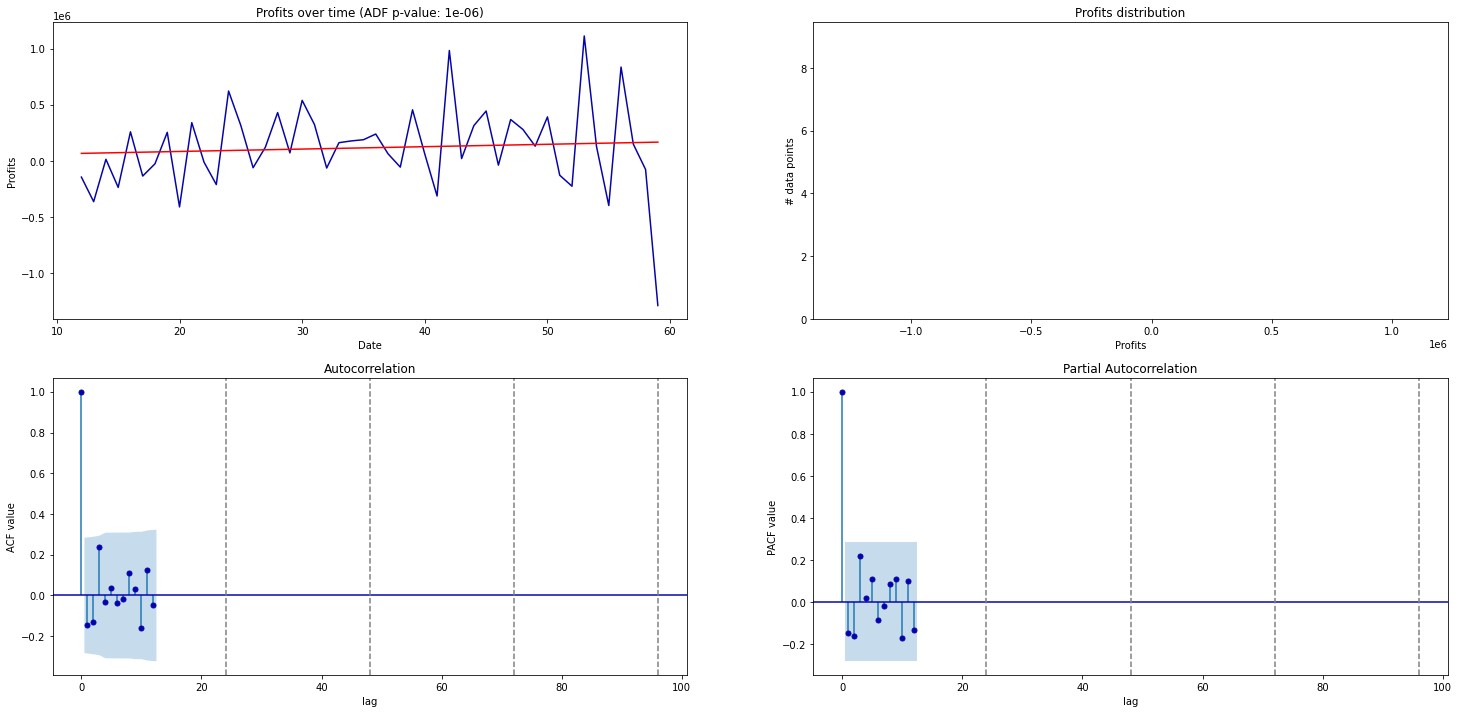

In [21]:
differenced = features.diff(12)[12:]
ts_analysis_plots(differenced['PROFIT'])

In [39]:
lags = range(1, 0, -1)
cols = features.columns.delete([0,1])

features_lag = features.assign(**{
    '{} (t-{})'.format(col, t): features[col].shift(t)
    for t in lags
    for col in cols
})[1:]


In [43]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaled = scaler.fit_transform(features_lag.values)

normalized_data = pd.DataFrame(scaled, columns=features_lag.columns)

print(normalized_data)

    TYEAR      TMON    PROFIT  PROFIT (t-1)
0    -1.0 -0.818182 -0.737544     -0.922355
1    -1.0 -0.636364 -0.354155     -0.737544
2    -1.0 -0.454545 -0.460671     -0.354155
3    -1.0 -0.272727  0.130210     -0.460671
4    -1.0 -0.090909  0.570874      0.130210
5    -1.0  0.090909  0.125864      0.570874
6    -1.0  0.272727  0.382328      0.125864
7    -1.0  0.454545  0.010685      0.382328
8    -1.0  0.636364 -0.591427      0.010685
9    -1.0  0.818182 -0.367882     -0.591427
10   -1.0  1.000000 -0.278283     -0.367882
11   -0.5 -1.000000 -1.000000     -0.278283
12   -0.5 -0.818182 -0.932844     -1.000000
13   -0.5 -0.636364 -0.346414     -0.932844
14   -0.5 -0.454545 -0.587679     -0.346414
15   -0.5 -0.272727  0.269575     -0.587679
16   -0.5 -0.090909  0.498302      0.269575
17   -0.5  0.090909  0.112086      0.498302
18   -0.5  0.272727  0.519180      0.112086
19   -0.5  0.454545 -0.209746      0.519180
20   -0.5  0.636364 -0.408066     -0.209746
21   -0.5  0.818182 -0.374075   

In [44]:
X = normalized_data.filter(regex = '^(?!(PROFIT)$).*$')
Y = normalized_data.filter(regex = '^PROFIT+$')

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.166667, random_state=13, shuffle=False)


X_train = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(49, 3, 1)
(10, 3, 1)


In [48]:
single_step_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(input_shape=(X_train.shape[1], X_train.shape[2]), units=X_train.shape[1], return_sequences=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(256),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

single_step_model.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

single_step_history = single_step_model.fit(X_train, Y_train, callbacks=[early_stopping], epochs=10, verbose=1)

Epoch 1/10
2/2 [==============================] - 3s 7ms/step - loss: 0.2376
Epoch 2/10
2/2 [==============================] - 0s 7ms/step - loss: 0.2376
Epoch 3/10
2/2 [==============================] - 0s 7ms/step - loss: 0.2047
Epoch 4/10
2/2 [==============================] - 0s 7ms/step - loss: 0.2130
Epoch 5/10
2/2 [==============================] - 0s 7ms/step - loss: 0.1877
Epoch 6/10
2/2 [==============================] - 0s 7ms/step - loss: 0.2069
Epoch 7/10
2/2 [==============================] - 0s 6ms/step - loss: 0.2141
Epoch 8/10
2/2 [==============================] - 0s 7ms/step 

In [59]:
single_step_model_pred = single_step_model.predict(X_test)

print(single_step_model_pred)
print(Y_test)

y_test_actual = scaler.inverse_transform(Y_test.values.reshape(Y_test.shape[0], 1))

print("MSE for predicted test set: %2f" % mean_squared_error(y_test_actual, single_step_model_pred))


[[-0.1156843 ]
 [-0.07255804]
 [-0.06213614]
 [-0.01813926]
 [ 0.00132655]
 [ 0.01136011]
 [ 0.01594338]
 [ 0.02093799]
 [ 0.01767875]
 [ 0.01026609]]
      PROFIT
49 -0.198073
50 -0.345865
51  0.412268
52  0.967300
53  1.000000
54  0.491391
55  0.374841
56 -0.001571
57 -0.339658
58 -0.373903


ValueError: non-broadcastable output operand with shape (10,1) doesn't match the broadcast shape (10,4)